### Extract collaboration graph based on co-editing patterns on the files

In [37]:
from config import repo_url, export_directory
from common import collect_commits
from collabgraph import extract_graph
from networkx.algorithms import bipartite
import networkx as nx

In [38]:
commits = collect_commits(repo_url)

In [59]:
def extract_collab_graph(commits, folders=None, filter_authors=True):
    bg, authors, file_paths = extract_graph(commits, folders=folders)
    for author in authors:
        bg.nodes[author]['weight'] = bg.degree[author]
    if filter_authors:
        authors = list(filter(lambda n: bg.degree(n) > 5, authors))
        
    g = nx.Graph()
    for n in authors:
        g.add_node(n, weight=bg.degree(n))
    for n0 in authors:
        for n1 in authors:
            w = len(set(bg.neighbors(n0)).intersection(set(bg.neighbors(n1))))
            if w > 1:
                g.add_edge(n0, n1, weight=w)
                g.add_edge(n1, n0, weight=w)
    return bg, g, authors, file_paths

In [60]:
bg, g, authors, file_paths = extract_collab_graph(commits, folders=None, filter_authors=True)
print(len(authors), len(g.nodes))

93 93


### Calculate Layout

In [61]:
from networkx.drawing import layout
positions1d = layout.spectral_layout(g, dim=1)
sortednodes = sorted(g.nodes, key=lambda nid: positions1d[nid][0])
for nid in g.nodes:
    g.nodes[nid]['x'] = float(positions1d[nid][0])
    
for i, nid in enumerate(sortednodes):
    g.nodes[nid]['order'] = i

### Another Way to Calculate Layout

In [62]:
from scipy.cluster import hierarchy
mat = nx.to_numpy_matrix(g)
Z = hierarchy.linkage(mat, method='average', metric='euclidean', optimal_ordering=True)
leaf_ordering = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, mat))
node_list = list(g.nodes)
leaf_ordering = [int(x) for x in list(leaf_ordering)]
for i, idx in enumerate(leaf_ordering):
    g.nodes[node_list[idx]]['order'] = i

### Store projected graph in a json file format

In [63]:
from networkx.readwrite import json_graph
import json
from pathlib import Path

DATA_PATH = Path(export_directory)
FILE_PATH = DATA_PATH / "collabgraph.json"

with open(FILE_PATH, 'w') as f:
    json.dump(json_graph.node_link_data(g),f)

In [64]:
from networkx.classes import function
function.density(g)

0.20009350163627865

### Visualize projected graph with matrix

In [50]:
def visualize_adjacency_matrix(g):

    import seaborn as sns
    import networkx as nx
    sns.set()

    # Convert the palette to vectors that will be drawn on the side of the matrix
    mat = nx.to_numpy_matrix(g)
    print(mat.shape)
    
    # Draw the full plot
    sns.clustermap(mat, xticklabels=authors, yticklabels=authors, center=0, vmin = 0, vmax = 10, cmap='vlag', figsize=(25, 25), linewidths=.0)

(108, 108)


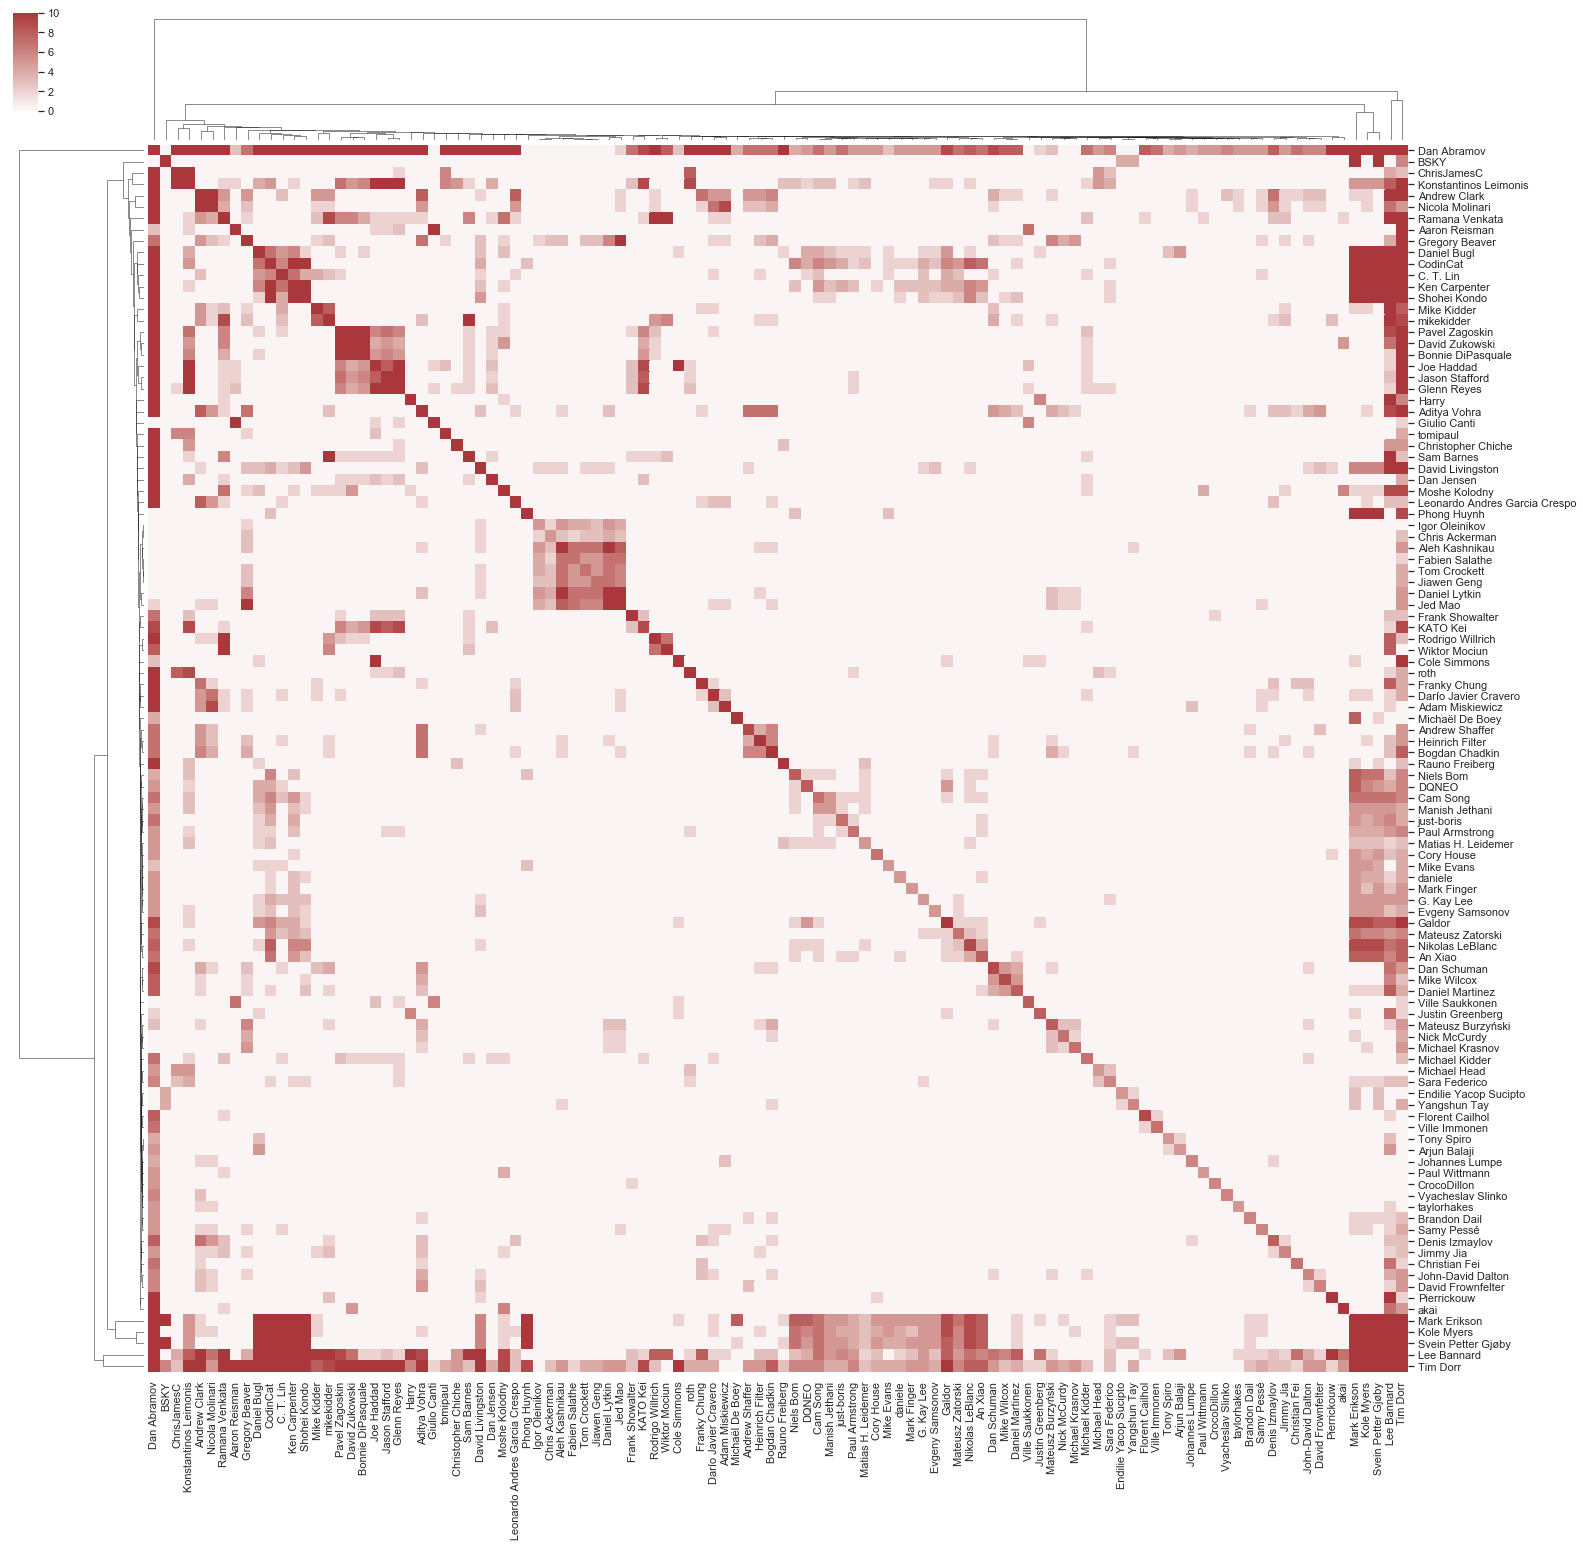

In [51]:
visualize_adjacency_matrix(g)

### Visualize Bipartite Graph with Matrix

In [59]:
from networkx.algorithms import bipartite
import seaborn as sns

biadjacency_mat = bipartite.matrix.biadjacency_matrix(bg, row_order=authors)

# mat = nx.to_numpy_matrix(g)

In [60]:
type(biadjacency_mat)

scipy.sparse.csr.csr_matrix

In [ ]:
import seaborn as sns

sns.clustermap(biadjacency_mat.toarray(),  center=0, xticklabels=file_paths, yticklabels=authors,  figsize=( 40, 20), cmap='vlag', linewidths=.05)


### Two filtering dimensions: 
- Time interval (or in-between which commits)
- Source code folder

### Node layout: 
- T-sne on co-editing patterns
- Overlap removal
- Node label layout

In [ ]:
def tsne_graph(g):
    from networkx.algorithms import shortest_paths
    dist_mat = shortest_paths.dense.floyd_warshall_numpy(g)
    from sklearn import manifold
    tsne = manifold.TSNE(metric='precomputed')
    return tsne.fit_transform(dist_mat)

In [ ]:
import altair as alt
import pandas as pd

embedding = tsne_graph(g)
pd = pd.DataFrame(embedding, columns=['x', 'y'])

alt.Chart(pd).mark_point().encode(
    x='x:Q',
    y='y:Q'
)

### Filter subgraph

In [67]:
rows = ["Jed Mao", "Daniel Lytkin", "Aleh Kashnikau", "Tom Crockett", "Jiawen Geng"]     
cols = ["Jed Mao", "Daniel Lytkin", "Aleh Kashnikau", "Tom Crockett", "Jiawen Geng"]

In [78]:
rows = ["Dan Abramov", "Lee Bannard", "Tim Dorr", "Mark Erikson", "Svein Petter Gjøby", "Kole Myers", "Konstantinos Leimonis"]

cols = rows


In [79]:
authors = set(rows)
authors.update(cols)
files = set()
for a in authors:
    files.update(bg.neighbors(a))

In [80]:
subgraph = bg.subgraph(list(authors) + list(files))

In [86]:
len(list(authors) + list(files))

852

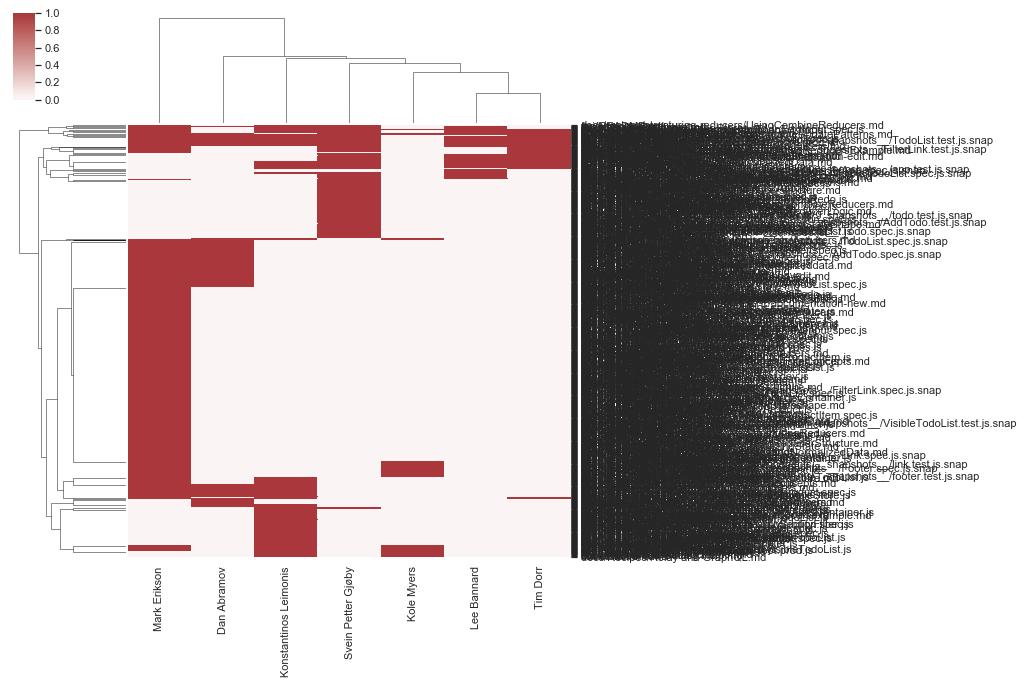

In [84]:
from networkx.algorithms import bipartite
import seaborn as sns
biadjacency_mat = bipartite.matrix.biadjacency_matrix(subgraph, row_order=authors)
import seaborn as sns
sns.clustermap(biadjacency_mat.transpose().toarray(),  center=0, xticklabels=authors, yticklabels=files, cmap='vlag', linewidths=.0)


In [91]:
from networkx.readwrite import json_graph, graphml
import json
from pathlib import Path

DATA_PATH = Path(export_directory)
FILE_PATH = DATA_PATH / "author_file_graph.json"
GML_FILE_PATH = DATA_PATH / "author_file_graph.graphml"

GML_FILE_PATH_M = DATA_PATH / "collabgraph.graphml"




    
graphml.write_graphml(subgraph, GML_FILE_PATH)
graphml.write_graphml(g, GML_FILE_PATH_M)

In [92]:
pos = nx.spring_layout(subgraph)

In [98]:
for k, v in pos.items():
    subgraph.nodes[k]['spring_layout'] = {
        'x': float(v[0]),
        'y': float(v[1])
    }
    

with open(FILE_PATH, 'w') as f:
    json.dump(json_graph.node_link_data(subgraph),f)